In [1]:
import os
import sys
sys.path.append(os.path.abspath("../"))

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

import math
from src.utils import reload_script
import warnings

from models_src.Support import LRCallback
from models_src.UNet_model import UNet
from models_src.Metrics import WeightedF12D, LossBasedMetric
import models_src.VecModels as vcm

from models_src.VecDataset import MultishapeMapGenerator, DatasetGenerator, blur_img, op_line_features
from models_src.fft_lib import xy_coords, decode1Dcoords, encode1Dcoords
from models_src.Trainer import TrainingProcessor2
from Fourier.datasets.generator_cfg import generator_cfg
%matplotlib inline

from models_src.Attn_variations import SqueezeImg, UnSqueezeImg

from models_src.DETR import FFN, MHA, HeadsPermuter

from models_src.Mask_RCNN import CombinedMetricsModel

print(tf.config.list_physical_devices('GPU'))

2024-09-16 13:54:54.609091: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 13:54:54.858821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 13:54:54.968642: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 13:54:54.998425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 13:54:55.171644: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1726487706.117585   51443 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726487706.353230   51443 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726487706.353331   51443 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.


In [60]:
reload_script('models_src.Trainer')

In [2]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("pixel_features_extraction")
mlflow.tensorflow.autolog(log_datasets=False, log_models=False, disable=True, checkpoint=False)

In [3]:
class cfg:
    train_batch_size = 32
    val_batch_size = 64
    test_batch_size = 8
    sample_points = 20
    #ds_path = './datasets/pixel_similarity'
    ds_path = './datasets/intense_lines'

msmg = MultishapeMapGenerator(['img', 'angle_label', 'center_vec_label', 'line_label', 'shape_label', 'thickness_label', 'pattern_masks', 'shape_masks', 'vecs_masks', 'bbox_masks', 'vecs', 'bboxes', 'vecs_mask', 'bbox_mask', 'shape_thickness'],
                              generator_cfg.size, 
                              **generator_cfg.drawing_args, 
                              patterns_prob=generator_cfg.patterns_prob, 
                              line_args=generator_cfg.line_args, 
                              shape_args=generator_cfg.shape_args, 
                              line_filled_args=generator_cfg.line_filled_args, 
                              polyline_args=generator_cfg.polyline_args, 
                              linear_shapes_args=generator_cfg.linear_shapes_args, 
                              spreaded_shapes_args=generator_cfg.spreaded_shapes_args
                              )

dg = DatasetGenerator(msmg, 
                      ds_path=cfg.ds_path, 
                      fold_size=512*4, 
                      parallel_calls=4, 
                      padded_batch=True, 
                      output_filter=['img','line_label', 'shape_label', 'angle_label', 'center_vec_label', 'thickness_label'],
                      preprocess_funcs=[(blur_img, {'blur_ratio_range': (0.1, 0.6), 'kernel_size': 3, 'color_rand_range': 0.1}, True),
                                        (op_line_features, {}, True)]
                      )

ds, train_steps = dg.dataset(from_saved=True, batch_size=cfg.train_batch_size, validation=False, val_idxs=[0], shuffle_buffer_size=128)
val_ds, val_steps = dg.dataset(from_saved=True, batch_size=cfg.val_batch_size, validation=True, val_idxs=[0])
test_ds, test_steps = dg.dataset(from_saved=True, batch_size=cfg.test_batch_size, validation=True, val_idxs=[0])

ds_iter = iter(ds)
val_iter = iter(val_ds)
test_iter = iter(test_ds)

I0000 00:00:1726487706.445683   51443 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726487706.446039   51443 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726487706.446086   51443 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726487706.750537   51443 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726487706.750972   51443 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-16

In [28]:
heads_extractor = HeadsPermuter(num_heads=1, reverse=False)

In [33]:
a = tf.ones((8,1024,64))
b = tf.ones((1,1024,1024,64))

Q = K = heads_extractor(a)
print(Q.shape)
scores =  tf.matmul(Q, K, transpose_b=True)
weights = tf.expand_dims(tf.nn.softmax(scores, axis=-1), axis=-2)
print(weights.shape)
V = tf.expand_dims(b, axis=-4)
print(V.shape)
V = tf.squeeze(tf.matmul(weights, V), axis=-2)
print(V.shape)

(8, 1, 1024, 64)
(8, 1, 1024, 1, 1024)
(1, 1, 1024, 1024, 64)
(8, 1, 1024, 64)


In [37]:

c, _ = vcm.SelfRadialMHA(output_dim=64, key_dim=64, value_dim=64, num_heads=1)(b,a,a)
print(c.shape)

(8, 1024, 64)


/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'self_radial_mha_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [4]:
backbone_args = {
    'input_shape': (32,32,3),
    'init_filters_power': 6,
    'levels': 3,
    'level_convs': 4,
    'init_dropout': 0.0,
    'dropout': 0.3,
    'batch_normalization': True,
    'name': 'PxFeaturesUnet'
}

model_args = {
    'enc_type': 'frequency',
    'num_heads': 1,
    'embs_dim': 64,
    'color_embs_dim': 64,
    'size': 32,
    'embs_mid_layers': 2,
    'dropout': 0.0,
    'activation': 'relu',
    'out_mid_layers': 2,
    'attns_num': 3,
    'concat_memory': False,
    'progressive': True,
    'inverted_angle': True,
    'backbone_args': backbone_args,
    'backbone_generator': vcm.pixel_features_unet,
    'backbone_weights_path': './final_state/PxFeatures/e45_ps',
    'backbone_trainable': False,
    'backbone_last_layer': 'Up-Conv_2',
    'backbone_init_layer': 'Batch-Normalization',
}

compile_args = {
    'optimizer': tf.keras.optimizers.Adam(1e-3),
    'loss': {
        'shape_class': tf.keras.losses.BinaryCrossentropy(name='LineDetLoss', reduction='sum_over_batch_size'), 
        'angle': vcm.AngleLoss(gamma=1., name='LnAngleLoss', reduction='sum_over_batch_size'), 
        'thickness': tf.keras.losses.MeanAbsoluteError(name='ThickLoss', reduction='sum_over_batch_size'),
        'center_vec': vcm.AngleLengthLoss(angle_gamma=1., length_gamma=1., dist_gamma=2., angle_weight=0.3, length_weight=0.7, dist_weight=1.0, name='CVLoss', reduction='sum_over_batch_size')
        },
    'loss_weights': {
        'shape_class': 0.25, 
        'angle': 0.25, 
        'thickness': 0.25,
        'center_vec': 0.25
        },
    'metrics': {'shape_class': WeightedF12D()}
}

model_generator = vcm.radial_enc_pixel_features_model_generator

In [5]:
trainer = TrainingProcessor2(cfg, mlflow_instance=mlflow)
trainer.load_dataset(ds, train_steps, val_ds, val_steps)
trainer.load_model_generator(model_generator)
trainer.compile_model(
    model_args = model_args,
    print_summary = True,
    summary_kwargs = {'expand_nested': True, 'line_length': 100},
    **compile_args
)

(1, 1024, 1024, 64) (None, 1024, 64)


/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'MHA_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'MHA_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'MHA_3', however the 

Model: "PxFeaturesRadEnc"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 32, 32, 3)       │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Batch-Normalization         │ (None, 32, 32, 3)       │             12 │ input_layer[0][0]       │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ RSFE                        │ [(None, 1024, 64), (1,  │         25,280 │ Batch-Normalization[0]… │
│ (RadialSearchFeaturesExtra… │ 1024, 1024, 64)]        │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│    └ RSFE-ColorEmbs-FFN     │ (None, 32, 32, 64)      │         25,280 │ -                       │
│ (FFN)                       │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│    └ RSFE-Squeeze-Features  │ ?                       │              0 │ -                       │
│ (SqueezeImg)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│    └ RSFE-Squeeze-PosEnc    │ ?                       │              0 │ -                       │
│ (SqueezeImg)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ MHA_1 (SelfRadialMHA)       │ [(None, 1024, 64),      │         12,480 │ RSFE[0][1], RSFE[0][0], │
│                             │ (None, 1, 1024, 1024)]  │                │ RSFE[0][0]              │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Decoder-FFN_1 (FFN)         │ (None, 1024, 64)        │         33,088 │ MHA_1[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Progressive-SkipCon-FFN_2   │ (None, 1024, 128)       │         41,344 │ Decoder-FFN_1[0][0]     │
│ (FFN)                       │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ MHA_2 (SelfRadialMHA)       │ [(None, 1024, 128),     │         33,152 │ RSFE[0][1],             │
│                             │ (None, 2, 1024, 1024)]  │                │ Decoder-FFN_1[0][0],    │
│                             │                         │                │ Decoder-FFN_1[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ PostMHA-AddNorm_2 (AddNorm) │ (None, 1024, 128)       │            256 │ Progressive-SkipCon-FF… │
│                             │                         │                │ MHA_2[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Decoder-FFN_2 (FFN)         │ (None, 1024, 128)       │        131,712 │ PostMHA-AddNorm_2[0][0] │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ PostFFN-AddNorm_2 (AddNorm) │ (None, 1024, 128)       │            256 │ PostMHA-AddNorm_2[0][0… │
│                             │                         │                │ Decoder-FFN_2[0][0]     │
├─────────────────────────────┼─────────────────────────┼────

 Total params: 1,498,964 (5.72 MB)

 Trainable params: 1,498,958 (5.72 MB)

 Non-trainable params: 6 (24.00 B)

None


In [55]:
for layer in trainer.model.layers:
    layer.trainable = True

In [6]:
trainer.train_model(
    epochs = 60,
    callbacks = [LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.96)],
    log = True,
    export_final_state = False,
    export_model = False
)

MLflow run: caring-bat-644


Epoch 1/60


I0000 00:00:1726487721.014462   70531 service.cc:146] XLA service 0x7f6ef800b040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726487721.014509   70531 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-09-16 13:55:21.304333: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-16 13:55:22.517903: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-16 13:55:24.140684: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_196', 16 bytes spill stores, 16 bytes spill loads

2024-09-16 13:55:24.218446: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in functio

512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.8940 - shape_class_F1: 0.7106

2024-09-16 13:56:31.433415: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 316 bytes spill stores, 268 bytes spill loads

2024-09-16 13:56:32.041305: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2', 12 bytes spill stores, 12 bytes spill loads

2024-09-16 13:56:33.475155: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 372 bytes spill stores, 372 bytes spill loads

2024-09-16 13:56:33.507096: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 8 bytes spill stores, 8 bytes spill loads

2024-09-16 13:56:34.573487: I external/local_xla/xla/stream_executor/

512/512 ━━━━━━━━━━━━━━━━━━━━ 92s 87ms/step - loss: 0.8937 - shape_class_F1: 0.7107 - val_loss: 0.4774 - val_shape_class_F1: 0.9479 - learning_rate: 0.0010
Epoch 2/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - loss: 0.4085 - shape_class_F1: 0.9504 - val_loss: 0.3514 - val_shape_class_F1: 0.9581 - learning_rate: 9.6000e-04
Epoch 3/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - loss: 0.3009 - shape_class_F1: 0.9642 - val_loss: 0.2638 - val_shape_class_F1: 0.9700 - learning_rate: 9.2160e-04
Epoch 4/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 0.2535 - shape_class_F1: 0.9711 - val_loss: 0.2368 - val_shape_class_F1: 0.9724 - learning_rate: 8.8474e-04
Epoch 5/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 0.2353 - shape_class_F1: 0.9730 - val_loss: 0.2258 - val_shape_class_F1: 0.9753 - learning_rate: 8.4935e-04
Epoch 6/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 0.2166 - shape_class_F1: 0.9735 - val_loss: 0.2059 - val_shape_class_F1: 0.9771 - learning_rate: 8.1537

2024/09/16 14:26:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-bat-644 at: http://localhost:5000/#/experiments/0/runs/f932813a32814986a921010b37f6b525.
2024/09/16 14:26:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


In [22]:
tf.config.experimental.get_memory_info('GPU:0')['peak']*1e-6

3244.6274559999997

In [7]:
trainer.save_temp_weights('./final_state', filename='e60_heavy_inv', use_model_name=True)

In [16]:
trainer.load_temp_weights('final_state/PxFeaturesRadEnc/e60_pure_radial', skip_mismatch=False)

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 150 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
mlflow.end_run(status="KILLED")

## validation

In [8]:
shape_class_metric = LossBasedMetric(tf.keras.losses.BinaryCrossentropy(name='LineDetLoss', reduction='sum_over_batch_size'))
angle_metric = LossBasedMetric(vcm.AngleLoss(gamma=1., name='LnAngleLoss', reduction='sum_over_batch_size'))
thickness_metric = LossBasedMetric(tf.keras.losses.MeanAbsoluteError(name='ThickLoss', reduction='sum_over_batch_size'))
center_vec_metric = LossBasedMetric(vcm.AngleLengthLoss(angle_gamma=1., length_gamma=1., dist_gamma=2., angle_weight=0.3, length_weight=0.7, dist_weight=1.0, name='CVLoss', reduction='sum_over_batch_size'))

@tf.function(input_signature=[tf.TensorSpec(shape=(cfg.test_batch_size,32,32,3), dtype=tf.float32), 
                            {
                                'shape_class': tf.TensorSpec(shape=(cfg.test_batch_size,32,32,3), dtype=tf.float32), 
                                'angle': tf.TensorSpec(shape=(cfg.test_batch_size,32,32,1), dtype=tf.float32), 
                                'thickness': tf.TensorSpec(shape=(cfg.test_batch_size,32,32,1), dtype=tf.float32),
                                'center_vec':tf.TensorSpec(shape=(cfg.test_batch_size,32,32,2), dtype=tf.float32)
                                },
                            {
                                'shape_class': tf.TensorSpec(shape=(cfg.test_batch_size,32,32), dtype=tf.float32), 
                                'angle': tf.TensorSpec(shape=(cfg.test_batch_size,32,32,1), dtype=tf.float32), 
                                'thickness': tf.TensorSpec(shape=(cfg.test_batch_size,32,32,1), dtype=tf.float32),
                                'center_vec':tf.TensorSpec(shape=(cfg.test_batch_size,32,32,1), dtype=tf.float32)
                                }
                              ], 
                              jit_compile=True, autograph=False)
def tf_eval(img, labels, weights):
    preds = trainer.model(img, training=False)

    shape_class_metric.update_state(labels['shape_class'], preds['shape_class'], weights['shape_class'])
    angle_metric.update_state(labels['angle'], preds['angle'], weights['angle'])
    thickness_metric.update_state(labels['thickness'], preds['thickness'], weights['thickness'])
    center_vec_metric.update_state(labels['center_vec'], preds['center_vec'], weights['center_vec'])

In [9]:
with tf.device('/GPU:0'):
    shape_class_metric.reset_state()
    angle_metric.reset_state()
    thickness_metric.reset_state()
    center_vec_metric.reset_state()

    pb = tf.keras.utils.Progbar(test_steps, stateful_metrics=['val_shape_class_loss','val_angle_loss', 'val_thickness_loss', 'val_center_vec_loss'])

    for i in range(test_steps):
        features, labels, labels_weights = next(test_iter)
        tf_eval(features, labels, labels_weights)
        pb.update(i+1, values=[('val_shape_class_loss', shape_class_metric.result().numpy()),
                               ('val_angle_loss', angle_metric.result().numpy()),
                               ('val_thickness_loss', thickness_metric.result().numpy()),
                               ('val_center_vec_loss', center_vec_metric.result().numpy())])
        
weighted_loss_value = np.mean([shape_class_metric.result().numpy(),angle_metric.result().numpy(),thickness_metric.result().numpy(),center_vec_metric.result().numpy()])
print('loss_value:', weighted_loss_value)

2024-09-16 14:26:19.473893: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 16 bytes spill stores, 16 bytes spill loads

2024-09-16 14:26:20.589774: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 372 bytes spill stores, 372 bytes spill loads

2024-09-16 14:26:21.668568: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_37', 368 bytes spill stores, 368 bytes spill loads

2024-09-16 14:26:21.748328: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 8 bytes spill stores, 8 bytes spill loads

2024-09-16 14:26:25.415069: I external/local_xla/xla/stream_execut

256/256 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - val_shape_class_loss: 0.0347 - val_angle_loss: 0.0788 - val_thickness_loss: 0.2280 - val_center_vec_loss: 0.1888
loss_value: 0.1325829


In [10]:
run_id = mlflow.search_runs(order_by=['start_time DESC']).iloc[0].run_id
with mlflow.start_run(run_id=run_id):
    for metric_name, metric_value in zip(['val_shape_class_loss', 'val_angle_loss', 'val_thickness_loss', 'val_center_vec_loss'], [m.result().numpy() for m in [shape_class_metric, angle_metric, thickness_metric, center_vec_metric]]):
        mlflow.log_metric(metric_name, metric_value)

2024/09/16 14:26:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run caring-bat-644 at: http://localhost:5000/#/experiments/0/runs/f932813a32814986a921010b37f6b525.
2024/09/16 14:26:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.


# Test

[0.99825704, 0.99587005, 0.99352336]


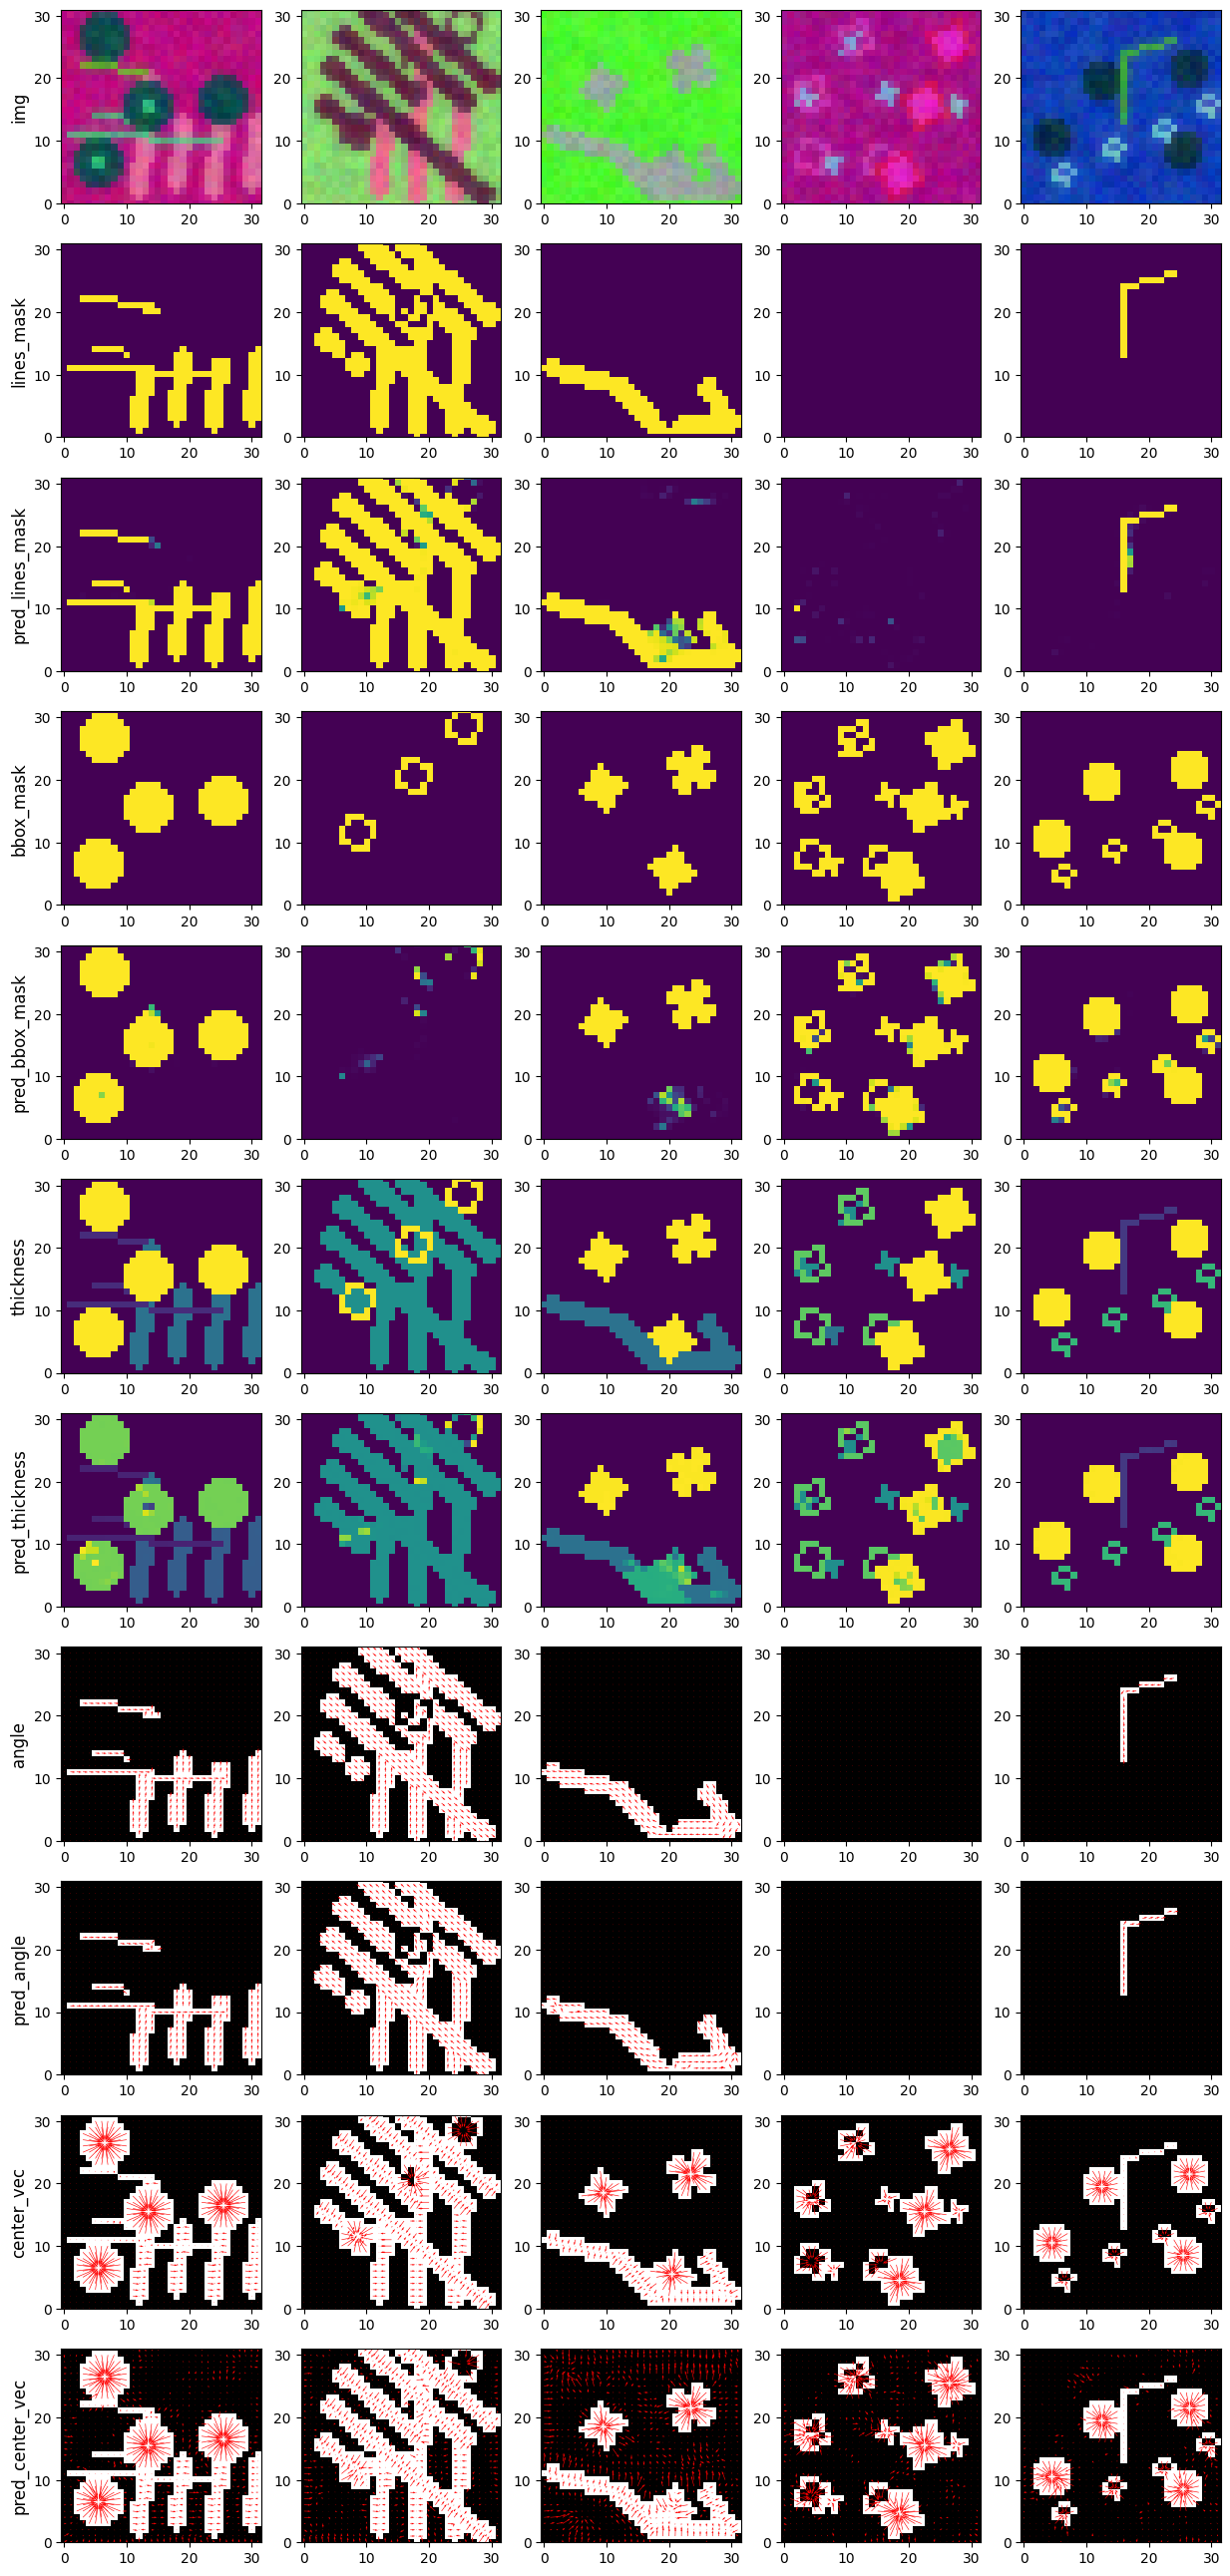

In [11]:
img, labels, weights = next(test_iter)

f1_loss = WeightedF12D()

shape_class, angle, thickness, center_vec = labels.values()
_, angle_mask, thickness_mask, center_vec_mask = [tf.where(elem>0, 1.0, 0.0) for elem in weights.values()]

background_mask, lines_mask, bbox_mask = tf.split(shape_class, 3, axis=-1)

pred_shape_class, pred_angle, pred_thickness, pred_center_vec = trainer.model(img, training=False).values()
pred_background_mask, pred_lines_mask, pred_bbox_mask = tf.split(pred_shape_class, 3, axis=-1)

pred_thickness *= thickness_mask
#pred_center_vec *= center_vec_mask
#pred_angle *= angle_mask

print([f1_loss(label, pred).numpy() for label, pred in zip([background_mask, lines_mask, bbox_mask], [pred_background_mask, pred_lines_mask, pred_bbox_mask])])

x, y = tf.split(xy_coords((32,32)), 2, axis=-1)

s = 5
fig, axs = plt.subplots(11, s, figsize=(s*3, 11*3))

for n in range(s):
    for i, plot_img in enumerate([img, lines_mask, pred_lines_mask, bbox_mask, pred_bbox_mask, thickness, pred_thickness]):
        axs[i,n].imshow(plot_img[n])
        axs[i,n].set_ylim(0,31)

    for i, plot_angle in enumerate([angle, pred_angle]):
        ay = tf.squeeze(tf.sin(plot_angle[n])*angle_mask[n], axis=-1)
        ax = tf.squeeze(tf.cos(plot_angle[n])*angle_mask[n], axis=-1)
        axs[i+7,n].imshow(angle_mask[n], cmap='gray')
        axs[i+7,n].quiver(x, y, ax, ay, color='red', width=0.003, scale=40)
        axs[i+7,n].set_ylim(0,31)

    for i, plot_vec in enumerate([center_vec, pred_center_vec]):

        axs[i+9,n].imshow(center_vec_mask[n], cmap='gray')
        axs[i+9,n].quiver(x, y, plot_vec[n,...,1], plot_vec[n,...,0], color='red', width=0.003, scale=40)
        axs[i+9,n].set_ylim(0,31)


for i, title in enumerate(['img', 'lines_mask', 'pred_lines_mask', 'bbox_mask', 'pred_bbox_mask', 'thickness', 'pred_thickness', 'angle', 'pred_angle', 'center_vec', 'pred_center_vec']):
    axs[i,0].set_ylabel(title, rotation=90, fontsize=12)

plt.show()

In [34]:
inter_model = tf.keras.Model(trainer.model.input, (trainer.model.get_layer('MHA_1').output[0], 
                                                   trainer.model.get_layer('MHA_1').output[1], 
                                                   trainer.model.get_layer('RSFE').output[1]))

learned_pos_enc, attn_mask, pos_enc = inter_model(img, training=False)
learned_pos_enc = tf.matmul(attn_mask[:,0,:,tf.newaxis], pos_enc)[:,:,0]
print(learned_pos_enc.shape, attn_mask.shape, pos_enc.shape)
flat_coord = encode1Dcoords(tf.constant([18,5]), width=32)[0]

sub_attn_mask = tf.reshape(attn_mask[1,0,flat_coord], (32,32))
sub_learned_pos_enc = learned_pos_enc[1,flat_coord,tf.newaxis]
sub_pos_enc = pos_enc[0,flat_coord]

print(sub_learned_pos_enc.shape, sub_pos_enc.shape)

learned_pos_map = tf.matmul(sub_learned_pos_enc, sub_pos_enc, transpose_b=True)
print(learned_pos_map.shape)
learned_pos_map = tf.reshape(learned_pos_map, (32,32))

(8, 1024, 64) (8, 1, 1024, 1024) (1, 1024, 1024, 64)
(1, 64) (1024, 64)
(1, 1024)


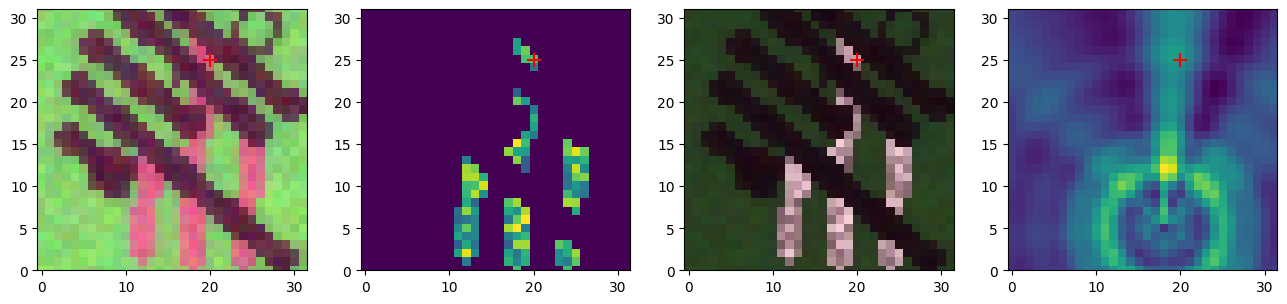

In [35]:

fig, axs = plt.subplots(1,4, figsize=(16,4))
axs[0].imshow(img[1])
axs[1].imshow(sub_attn_mask)

axs[2].imshow(img[1])
axs[2].imshow(sub_attn_mask, cmap='gray', alpha=0.7)

axs[3].imshow(learned_pos_map)
for i in range(4):
    axs[i].scatter(20,25, marker='+', color='red', s=100)
    axs[i].set_ylim(0,31)